In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import lightgbm as lgb
import seaborn as sns

In [4]:
data_chemicals = pd.read_csv("chemicals.csv")
data_drought = pd.read_csv("droughts.csv")
data_education = pd.read_csv("education_attainment.csv", encoding = 'latin1')
data_water = pd.read_csv("water_usage.csv")
water_info = pd.read_csv("water_usage_dictionary.csv")
data_industry_occ = pd.read_csv("industry_occupation.csv", encoding='latin1')

In [5]:
data_chemicals.head()

,cws_name,chemical_species,contaminant_level,county,pws_id,pop_served,state,unit_measurement,value,year,fips,state_fips
0,CALIFORNIA WATER SERVICE - LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110003,57200,California,micrograms/L,1.54,2000,6001,6
1,CITY OF LIVERMORE,Uranium,Less than or equal MCL,Alameda,CA0110011,26400,California,micrograms/L,1.64,2000,6001,6
2,CITY OF PLEASANTON,Uranium,Less than or equal MCL,Alameda,CA0110008,70600,California,micrograms/L,1.64,2000,6001,6
3,DUBLIN SAN RAMON SERVICES DISTRICT,Uranium,Less than or equal MCL,Alameda,CA0110009,72500,California,micrograms/L,1.64,2000,6001,6
4,NORRIS CANYON PROPERTY OWNERS ASSN,Uranium,Less than or equal MCL,Alameda,CA0103040,100,California,micrograms/L,4.51,2000,6001,6


## Pollution index by county

In [6]:
data_chemicals['greater_than_MCL'] = (data_chemicals['contaminant_level'] == "Greater than MCL") * 1.
groups = data_chemicals.groupby("cws_name")[['greater_than_MCL', 'fips', "pop_served"]].mean()
groups['index_with_weights'] = groups['greater_than_MCL']*groups['pop_served']
chemicals_index = groups.groupby("fips")['index_with_weights'].sum() / groups.groupby("fips")['pop_served'].sum()

In [7]:
chemicals_index.head()

fips
6001.0    0.000000
6003.0    0.000000
6005.0    0.000000
6007.0    0.002989
6009.0    0.000000
dtype: float64

## Drought index by county

In [8]:
data_drought['valid_start'] = pd.to_datetime(data_drought['valid_start'])
data_drought['valid_end'] = pd.to_datetime(data_drought['valid_end'])

In [9]:
data_drought['event_duration_in_days'] = (data_drought['valid_end'] - data_drought['valid_start']).dt.days

In [10]:
data_drought['event_importance_with_weight'] = data_drought['event_duration_in_days'] * 0. + (data_drought['d0']*1. + data_drought['d1']*2. + data_drought['d2']*3. + data_drought['d3']*4. + data_drought['d4']*5.) / 100.
groups = data_drought.groupby("fips")
drought_index = groups['event_importance_with_weight'].sum() / groups['event_duration_in_days'].sum()

In [11]:
data_drought.head()

,fips,county,state,none,d0,d1,d2,d3,d4,valid_start,valid_end,event_duration_in_days,event_importance_with_weight
0,2013,Aleutians East Borough,AK,100.0,0.0,0.0,0.0,0.0,0.0,2017-12-26,2018-01-01,6,0.0
1,2013,Aleutians East Borough,AK,100.0,0.0,0.0,0.0,0.0,0.0,2017-12-19,2017-12-25,6,0.0
2,2013,Aleutians East Borough,AK,100.0,0.0,0.0,0.0,0.0,0.0,2017-12-12,2017-12-18,6,0.0
3,2013,Aleutians East Borough,AK,100.0,0.0,0.0,0.0,0.0,0.0,2017-12-05,2017-12-11,6,0.0
4,2013,Aleutians East Borough,AK,100.0,0.0,0.0,0.0,0.0,0.0,2017-11-28,2017-12-04,6,0.0


In [12]:
drought_index.head()

fips
1001    0.145533
1003    0.143284
1005    0.234105
1007    0.119415
1009    0.109820
dtype: float64

In [13]:
drought_index = drought_index.rename("drought_index")
drought_index = pd.DataFrame(drought_index)

## Education index by county

In [14]:
data_education.head()

,fips,state,county,year,less_than_hs,hs_diploma,some_college_or_associates,college_bachelors_or_higher,pct_less_than_hs,pct_hs_diploma,pct_college_or_associates,pct_college_bachelors_or_higher,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,0,US,United States,1970,52373312.0,34158051.0,11650730.0,11717266.0,47.7,31.1,10.6,10.7,NaN,NaN,NaN
1,1000,AL,Alabama,1970,1062306.0,468269.0,136287.0,141936.0,58.7,25.9,7.5,7.8,NaN,NaN,NaN
2,1001,AL,Autauga County,1970,6611.0,3757.0,933.0,767.0,54.8,31.1,7.7,6.4,NaN,NaN,NaN
3,1003,AL,Baldwin County,1970,18726.0,8426.0,2334.0,2038.0,59.4,26.7,7.4,6.5,NaN,NaN,NaN
4,1005,AL,Barbour County,1970,8120.0,2242.0,581.0,861.0,68.8,19.0,4.9,7.3,NaN,NaN,NaN


In [15]:
data_education['avg_higher_education_years'] = (data_education['pct_less_than_hs'] * (-3) + data_education['pct_hs_diploma'] * 0. + data_education['pct_college_or_associates']*3. + data_education['pct_college_bachelors_or_higher']*4.)/100.

In [16]:
data_education.head()

,fips,state,county,year,less_than_hs,hs_diploma,some_college_or_associates,college_bachelors_or_higher,pct_less_than_hs,pct_hs_diploma,pct_college_or_associates,pct_college_bachelors_or_higher,Unnamed: 12,Unnamed: 13,Unnamed: 14,avg_higher_education_years
0,0,US,United States,1970,52373312.0,34158051.0,11650730.0,11717266.0,47.7,31.1,10.6,10.7,NaN,NaN,NaN,-0.685
1,1000,AL,Alabama,1970,1062306.0,468269.0,136287.0,141936.0,58.7,25.9,7.5,7.8,NaN,NaN,NaN,-1.224
2,1001,AL,Autauga County,1970,6611.0,3757.0,933.0,767.0,54.8,31.1,7.7,6.4,NaN,NaN,NaN,-1.157
3,1003,AL,Baldwin County,1970,18726.0,8426.0,2334.0,2038.0,59.4,26.7,7.4,6.5,NaN,NaN,NaN,-1.300
4,1005,AL,Barbour County,1970,8120.0,2242.0,581.0,861.0,68.8,19.0,4.9,7.3,NaN,NaN,NaN,-1.625


### Water usage

In [17]:
data_water.head()

,state,state_fips,county,county_fips,fips,year,population,pub_sup_1,pub_sup_2,pub_sup_3,...,thermoelectric_30,gro_wat_1,gro_wat_2,gro_wat_3,surf_wat_1,surf_wat_2,surf_wat_3,total_withdrawal_1,total_withdrawal_2,total_withdrawal_3
0,AL,1,Autauga County,1,1001,2010,54.571,NaN,NaN,48.222,...,6738.26,18.38,0.0,18.38,37.17,0.0,37.17,55.55,0.0,55.55
1,AL,1,Baldwin County,3,1003,2010,182.265,NaN,NaN,153.463,...,0.00,57.35,0.0,57.35,7.01,0.0,7.01,64.36,0.0,64.36
2,AL,1,Barbour County,5,1005,2010,27.457,NaN,NaN,25.555,...,0.00,6.71,0.0,6.71,4.34,0.0,4.34,11.05,0.0,11.05
3,AL,1,Bibb County,7,1007,2010,22.915,NaN,NaN,21.279,...,0.00,6.06,0.0,6.06,1.55,0.0,1.55,7.61,0.0,7.61
4,AL,1,Blount County,9,1009,2010,57.322,NaN,NaN,44.464,...,0.00,4.04,0.0,4.04,53.04,0.0,53.04,57.08,0.0,57.08


In [18]:
water_info.head()

,state,State postal abbreviation
0,state_fips,State FIPS code
1,county,County name
2,county_fips,County FIPS code
3,fips,Concatenated State-county FIPS code
4,year,Year of data=2010


In [19]:
new_cat = ['Domestic', 'Public', 'Irrigation_acres', 'Irrigation_crop', 'Irrigation_golf', 'Mining', 'Industry', 'Livestock',
           'Aquaculture', 'Thermoelectric', 'Ground', 'Surface', 'Total']
identifiers = ['dom', 'pub', 'irr', 'cro', 'gol', 'min', 'in', 'live',
           'aqua', 'thermo', 'gro', 'surf', 'total']

for i in range(13):
    data_water[new_cat[i]] = data_water.loc[:,list(data_water.columns[data_water.columns.str.startswith(identifiers[i])])].sum(axis=1)


data_water_0 = data_water.loc[:, ['Total', 'fips']].set_index('fips')

In [20]:
data_water_0 = data_water_0.join(drought_index)
data_water_0.head()

,Total,drought_index
fips,,
1001,111.10,0.145533
1003,128.72,0.143284
1005,22.10,0.234105
1007,15.22,0.119415
1009,114.16,0.109820


In [21]:
data_industry_occ.columns

Index(['geo_id', 'fips', 'county', 'total_employed', 'agriculture',
       'construction', 'manufacturing', 'wholesale_trade', 'retail_trade',
       'transport_utilities', 'information', 'finance_insurance_realestate',
       'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other',
       'public_admin', 'year'],
      dtype='object')

In [22]:
columns_to_select = ['fips', 'total_employed', 'agriculture', 'construction', 'manufacturing', 'wholesale_trade', 'retail_trade', 'transport_utilities', 'information', 'finance_insurance_realestate',
'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other', 'public_admin']
data_ind = data_industry_occ.loc[data_industry_occ['year'] == 2010, columns_to_select].set_index('fips')
#data_ind.index
data_ind.dropna(subset=['total_employed'],inplace=True)
data_ind.fillna(0, inplace=True)

data_ind.loc[:,:] =data_ind.values / data_ind['total_employed'].values.reshape(-1,1)
data_ind = data_ind.iloc[:, 1:]

In [23]:
data_ind = data_ind.fillna(0)
data_ind.head()

,agriculture,construction,manufacturing,wholesale_trade,retail_trade,transport_utilities,information,finance_insurance_realestate,prof_scientific_waste,edu_health,arts_recreation,other,public_admin
fips,,,,,,,,,,,,,
1003,0.016852,0.083986,0.079391,0.027581,0.123280,0.046038,0.012166,0.076272,0.127784,0.190945,0.106869,0.046271,0.062566
1015,0.007880,0.032057,0.183969,0.017536,0.133418,0.038019,0.018215,0.052235,0.088290,0.195263,0.088828,0.057052,0.087238
1069,0.017374,0.065252,0.093182,0.041720,0.136903,0.062415,0.014735,0.043545,0.076050,0.216472,0.114361,0.058456,0.059534
1073,0.006084,0.061087,0.093593,0.030606,0.117545,0.050879,0.028706,0.086442,0.100755,0.233647,0.091058,0.054682,0.044916
1077,0.023900,0.090422,0.108259,0.034461,0.152775,0.062505,0.011091,0.044744,0.068467,0.217882,0.089715,0.079533,0.016245


In [44]:
data_1 = data_water_0.join(data_ind)
data_1['Total'] = (data_1['Total'] - data_1['Total'].mean()) / data_1['Total'].std()

In [45]:
data_1 = data_1.dropna()
data_1.head()

,Total,drought_index,agriculture,construction,manufacturing,wholesale_trade,retail_trade,transport_utilities,information,finance_insurance_realestate,prof_scientific_waste,edu_health,arts_recreation,other,public_admin
fips,,,,,,,,,,,,,,,
1003,-0.155671,0.143284,0.016852,0.083986,0.079391,0.027581,0.123280,0.046038,0.012166,0.076272,0.127784,0.190945,0.106869,0.046271,0.062566
1015,-0.275294,0.138964,0.007880,0.032057,0.183969,0.017536,0.133418,0.038019,0.018215,0.052235,0.088290,0.195263,0.088828,0.057052,0.087238
1069,0.027534,0.205546,0.017374,0.065252,0.093182,0.041720,0.136903,0.062415,0.014735,0.043545,0.076050,0.216472,0.114361,0.058456,0.059534
1073,-0.097754,0.120743,0.006084,0.061087,0.093593,0.030606,0.117545,0.050879,0.028706,0.086442,0.100755,0.233647,0.091058,0.054682,0.044916
1077,-0.315601,0.089812,0.023900,0.090422,0.108259,0.034461,0.152775,0.062505,0.011091,0.044744,0.068467,0.217882,0.089715,0.079533,0.016245


In [46]:
X = data_1.iloc[:,1:].values
Y = data_1.iloc[:,0].values
print(X.shape)
print(Y.shape)

(693, 14)
(693,)


In [47]:
reg = LinearRegression().fit(X, Y.reshape(-1,1))

In [48]:
data_1.columns

Index(['Total', 'drought_index', 'agriculture', 'construction',
       'manufacturing', 'wholesale_trade', 'retail_trade',
       'transport_utilities', 'information', 'finance_insurance_realestate',
       'prof_scientific_waste', 'edu_health', 'arts_recreation', 'other',
       'public_admin'],
      dtype='object')

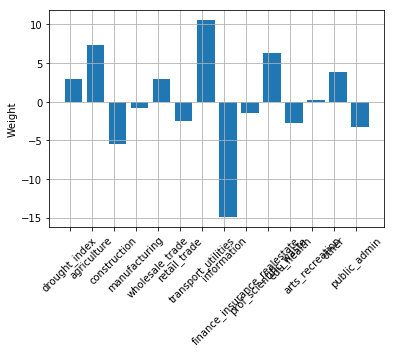

In [49]:
ind = np.arange(len(reg.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, reg.coef_.flatten())
ax.set_xticks(ind+width/2.)
ax.set_xticklabels(list(data_1.columns[1:]))
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Weight")
plt.show()

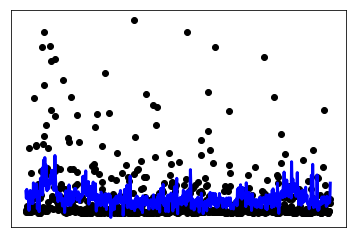

In [50]:
plt.scatter(range(Y.shape[0]), Y,  color='black')
plt.plot(range(Y.shape[0]), reg.predict(X), color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [51]:
print(reg.intercept_)

[0.60954255]


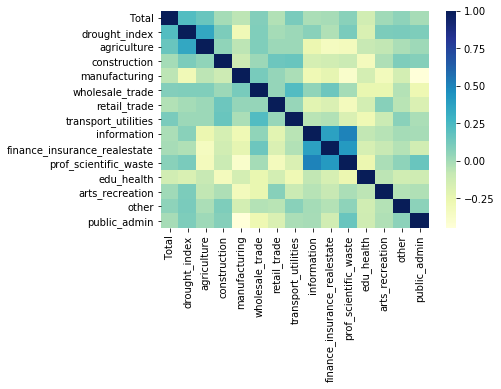

In [53]:
joined_table = data_1

# calculate the correlation matrix
corr = joined_table.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, cmap="YlGnBu")
plt.show()

In [63]:
print(.shape)

print(ind.shape)

(14,)
(14,)


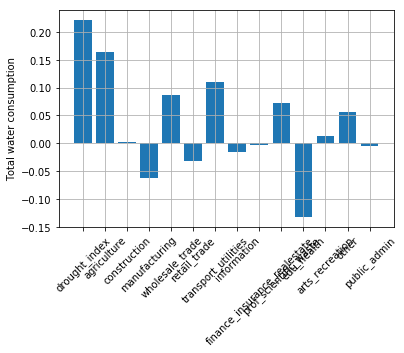

In [68]:
ind = np.arange(len(reg.coef_.flatten()))
width = 0.35
fig, ax = plt.subplots()
ax.bar(ind+width, corr.loc['Total','drought_index':].values)
ax.set_xticks(ind+width)
ax.set_xticklabels(list(data_1.columns[1:]))
plt.xticks(rotation=45)
plt.grid()
plt.ylabel("Total water consumption")
plt.show()

In [69]:
list(data_1.columns[1:])

['drought_index',
 'agriculture',
 'construction',
 'manufacturing',
 'wholesale_trade',
 'retail_trade',
 'transport_utilities',
 'information',
 'finance_insurance_realestate',
 'prof_scientific_waste',
 'edu_health',
 'arts_recreation',
 'other',
 'public_admin']